In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50 as resnet

In [2]:
import cv2
import os
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation, Dropout,Flatten,Conv2D,MaxPool2D,Dense, BatchNormalization, Input, AveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

In [3]:
! git clone https://github.com/AnnaFilipov93/ReLeaf

Cloning into 'ReLeaf'...
remote: Enumerating objects: 14767, done.
remote: Total 14767 (delta 0), reused 0 (delta 0), pack-reused 14767
Receiving objects: 100% (14767/14767), 783.17 MiB | 20.26 MiB/s, done.
Resolving deltas: 100% (103/103), done.
Checking out files: 100% (13651/13651), done.


In [9]:
BATCH_SIZE=32
STEP=4579// BATCH_SIZE
VALID_STEPS=1243  // BATCH_SIZE
SHAPE = (132,132)
INIT_LR = 1e-4


In [10]:
#prepering the data
train_image_gen=ImageDataGenerator(rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")

val_image_gen=ImageDataGenerator(rescale=1./255)


In [11]:
##~~reading the data ~~##
train_dir=os.path.join(os.getcwd(),'ReLeaf/flowers_after_detection/train')
test_dir=os.path.join(os.getcwd(), 'ReLeaf/flowers_after_detection/test')

train_img=train_image_gen.flow_from_directory(train_dir,
                                         target_size=SHAPE, batch_size=BATCH_SIZE,
                                         class_mode='categorical')


test_img=train_image_gen.flow_from_directory(test_dir,
                                       target_size=SHAPE, batch_size=BATCH_SIZE,
                                       shuffle = False, class_mode='categorical') 

                                     
train_img.class_indices

Found 4579 images belonging to 7 classes.
Found 1243 images belonging to 7 classes.


{'daisy': 0,
 'dandelion': 1,
 'iris': 2,
 'rose': 3,
 'sunflower': 4,
 'tulip': 5,
 'water lilies': 6}

In [12]:
baseModel = resnet(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(132, 132, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(7, activation="softmax")(headModel)


In [18]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
for layer in baseModel.layers:
	layer.trainable = False

In [20]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
#before manual opt - acc - 95% | val acc - 85% | 20 epochs
#after acc - 88% | val acc - 85% | 10 epochs
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_img,epochs=25, steps_per_epoch=STEP,
    validation_data=test_img, validation_steps=VALID_STEPS)

Epoch 1/25
143/143 [==============================] - 40s 278ms/step - loss: 1.1185 - accuracy: 0.6165 - val_loss: 0.3631 - val_accuracy: 0.8939
Epoch 2/25
143/143 [==============================] - 38s 262ms/step - loss: 0.4883 - accuracy: 0.8280 - val_loss: 0.2858 - val_accuracy: 0.9137
Epoch 3/25
143/143 [==============================] - 38s 264ms/step - loss: 0.4040 - accuracy: 0.8603 - val_loss: 0.2392 - val_accuracy: 0.9169
Epoch 4/25
143/143 [==============================] - 38s 264ms/step - loss: 0.3381 - accuracy: 0.8845 - val_loss: 0.2204 - val_accuracy: 0.9309
Epoch 5/25
143/143 [==============================] - 38s 264ms/step - loss: 0.3154 - accuracy: 0.8889 - val_loss: 0.2028 - val_accuracy: 0.9408
Epoch 6/25
143/143 [==============================] - 37s 260ms/step - loss: 0.2861 - accuracy: 0.9017 - val_loss: 0.1927 - val_accuracy: 0.9375
Epoch 7/25
143/143 [==============================] - 37s 260ms/step - loss: 0.2587 - accuracy: 0.9120 - val_loss: 0.1887 - val_ac

In [21]:
model.save('7-flowers-classifier.h5')

In [ ]:

print( os.getcwd() )
print( os.listdir('data') )

In [ ]:
from google.colab import files
files.download( "data/dm.ckpt.meta" ) 

In [ ]:
!pip install mlxtend --upgrade --no-deps

In [ ]:
labels = train_img.class_indices
Y_pred = model.predict_generator(test_img)
y_pred = np.argmax(Y_pred, axis=1)
print(labels)
mat=confusion_matrix(test_img.classes,y_pred)
print(mat)
plot_confusion_matrix(mat,figsize=(7,7),class_names = labels)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
with open('/content/drive/My Drive/flowers-analyzer/4-leaves-model.h5', 'w') as f:
  f.write('/content/4-leaves-classifier.h5')

In [ ]:
plt.plot(history.history['accuracy'])


In [ ]:
# In case the model pre-trained
model=load_model('/content/flowers-analyzer/7-flowers-classifier.h5')

----------------------------------------------------------- NOT FINE TUNED RESNET BELOW ------------------------------------------------------------------------

In [ ]:
def resnet50_train():
    model = Sequential()

    model.add(resnet(include_top=False, pooling='avg', weights='imagenet'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit_generator(
        train_img,epochs=20, steps_per_epoch=STEP,
        validation_data=test_img, validation_steps=VALID_STEPS)

    return model


In [ ]:
model = resnet50_train()

----- WITH BIAS : loss: 0.3830 - accuracy: 0.8700 - val_loss: 0.6431 - val_accuracy: 0.8012
----- WITHOUT BIAS : loss: 0.4067 - accuracy: 0.8603 - val_loss: 0.6585 - val_accuracy: 0.8000

In [ ]:
from IPython.display import Image, display

import os, random
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
img_locations = []
for d in os.listdir("flowers-analyzer/new_flowers_data/test/"):
    directory = "flowers-analyzer/new_flowers_data/test/" + d
    sample = [directory + '/' + s for s in random.sample(
        os.listdir(directory), int(random.random()*10))]
    img_locations += sample

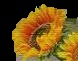

sunflower


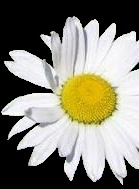

daisy


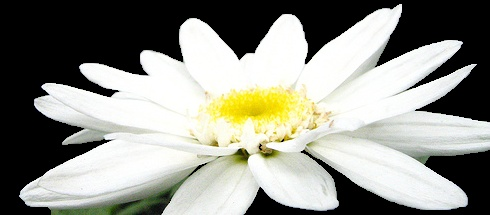

daisy


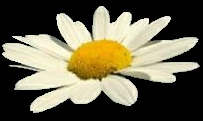

daisy


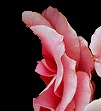

iris


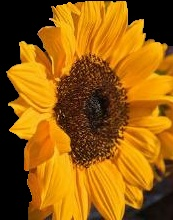

sunflower


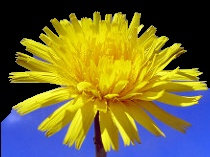

dandelion


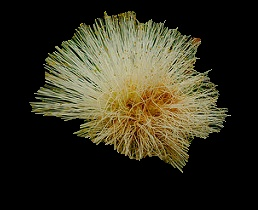

dandelion


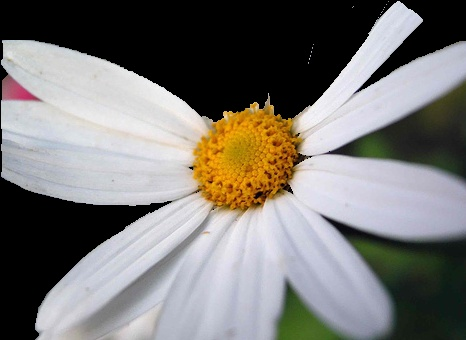

daisy


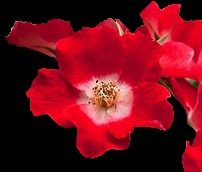

iris


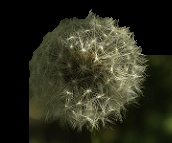

dandelion


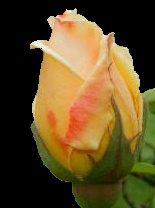

tulip


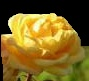

rose


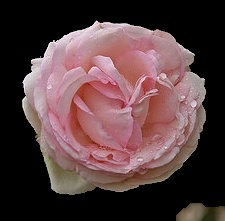

rose


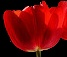

tulip


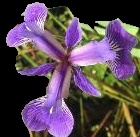

iris


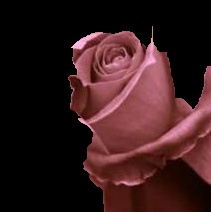

rose


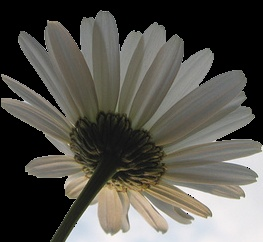

dandelion


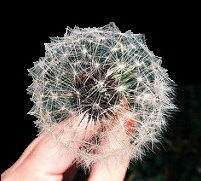

dandelion


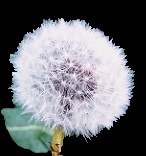

dandelion


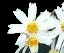

daisy


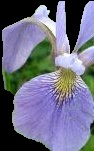

iris


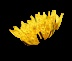

dandelion


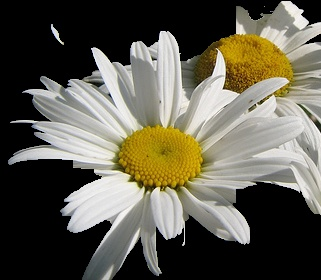

daisy


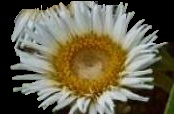

sunflower


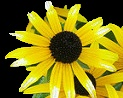

sunflower


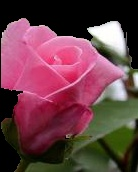

tulip


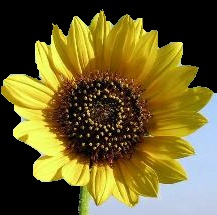

sunflower


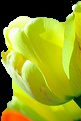

tulip


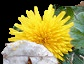

dandelion


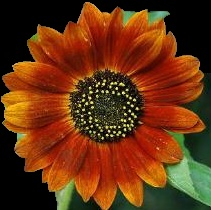

sunflower


In [ ]:
def read_and_prep_images(img_paths, img_height=132, img_width=132):
    imgs = [load_img(img_path, target_size=(132, 132)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

random.shuffle(img_locations)
imgs = read_and_prep_images(img_locations)
predictions = model.predict_generator(imgs)
classes = dict((v,k) for k,v in train_img.class_indices.items())

for img, prediction in zip(img_locations, predictions):
    display(Image(img))
    print(classes[np.argmax(prediction)])

In [ ]:
'''def train_model():
    ###~~~building the model~~~###

    model=Sequential()

    #conv layer I
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(240,240,3),
                    activation='relu'))
    #pooling layer I
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #conv layer II
    model.add(Conv2D(filters=64, kernel_size=(3,3),
                    activation='relu'))
    #pooling layer II
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #conv layer III
    model.add(Conv2D(filters=64, kernel_size=(3,3),
                    activation='relu'))
    #pooling layer III
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #conv layer IV
    model.add(Conv2D(filters=64, kernel_size=(3,3),
                    activation='relu'))
    #pooling layer IV
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    #conv layer V
    #model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(240,240,3),
    #                 activation='relu'))
    #pooling layer V
    #model.add(MaxPool2D(pool_size=(2,2)))

    #conv layer VI
    #model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(240,240,3),
    #                 activation='relu'))
    #pooling layer VI
    #model.add(MaxPool2D(pool_size=(2,2)))

    #flatten
    model.add(Flatten())

    #Dense layer
    model.add(Dense(512,activation='relu'))

    #dropout layer
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    #output layer
    model.add(Dense(5,activation='softmax'))

    model.summary()

    #compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    ###~~~training the model~~~###

    results=model.fit_generator(train_img,epochs=1, steps_per_epoch=1,
                                validation_data=test_img, validation_steps=27)

    return model'''

---------- manual checking of the model performence ---------------

In [ ]:
###~~~testing on the tests images~~~###

examples = ['FLOWERS//test//daisy/144076848_57e1d662e3_m.jpg',
            'FLOWERS//test//dandelion/14740350060_a489d9fa06.jpg',
            'FLOWERS//test/tulip/5633266048_4f4bfb2cf1_n.jpg',
            'FLOWERS//test/sunflower/21728822928_9f6817325a_n.jpg',
            'flowers//FLOWERS//test//rose/random_flower.jpg']


In [ ]:
def pred (p, pred_acc):
    if pred_acc[0,p]<0.7:
        print("the model couldn't recognize it")
    elif p==0:
        print("the model recognized it as a daisy")
    elif p==1:
         print("the model recognized it as a dandelion")
    elif p==2:
          print("the model recognized it as a rose")
    elif p==3:
          print("the model recognized it as a sunflower")       
    elif p==4:
          print("the model recognized it as a tulip")     
            

In [ ]:
def predict_flower(path):
  flower=cv2.imread(path)
  flower=cv2.cvtColor(flower,cv2.COLOR_BGR2RGB)
  plt.imshow(flower)

  flower_file=path
  flower_img=image.load_img(flower_file, target_size=(240,240))
  flower_img=image.img_to_array(flower_img)
  flower_img=np.expand_dims(flower_img,axis=0)
  flower_img=flower_img/255

  p=model.predict_classes(flower_img)
  pred(p)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()